# Credit Card Fraud Detection

# Udacity Machine Learning Nanodegree Capstone Project

----
17.Nov.2018<br/>
Talita Shiguemoto


## Overview

According to * Konduto *, every five seconds an attempted cloned credit card fraud occurs in Brazilian * e-commerces *. According to the same company, last year Brazil suffered about 6 million fraudulent purchases. Compared to others, a study conducted in 2016 by Business Insider Intelligence showed Brazil second in the ranking of the highest percentage of consumers exposed to fraudulent credit card transactions in the last five years.
This study was initiated to understand how to combat this national scenario, aiming to create an algorithm for detecting transactions with fraud based on the set of data extracted from * Kaggle *.

In [1]:
# Import the libraries required for this project
import pandas as pd
import numpy as np
from time import time
from IPython.display import display # Permite o uso de display() para DataFrames
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#PreProcessing
from sklearn.preprocessing import MinMaxScaler 
from imblearn.combine import SMOTETomek # resampling with SMOTE with Tome links
from sklearn.model_selection import train_test_split # split data in training and test

# Models
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from xgboost.sklearn import XGBClassifier


# Metrics
from sklearn.model_selection import GridSearchCV # to optimize the hyperparameters
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Check normality
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import normaltest

# Show matplotlib in body text (well formatted in Notebook)
%matplotlib inline

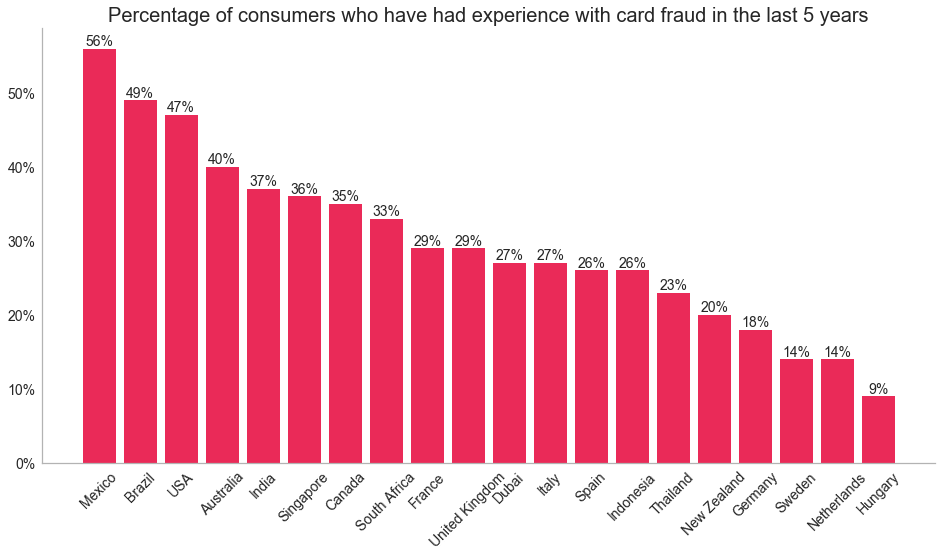

In [2]:
# Adapted Chart from Business Insider Intelligence 
# Font:https://www.businessinsider.com/the-us-has-the-third-highest-card-fraud-rate-in-the-world-2016-7

paises = [
    'Mexico', 'Brazil', 'USA', 
    'Australia', 'India', 'Singapore',
    'Canada', 'South Africa', 'France',
    'United Kingdom', 'Dubai', 'Italy',
    'Spain', 'Indonesia', 'Thailand',
    'New Zealand', 'Germany', 'Sweden',
    'Netherlands', 'Hungary'
]

taxa_fraude = [
    56, 49, 47, 40, 37,
    36, 35, 33, 29, 29,
    27, 27, 26, 26, 23,
    20, 18, 14, 14, 9    
]

# Graph palette
palette=[
    '#ea2a58','#06598b', '#69c1b8',
    '#cbe6e7', '#78b343', '#f6dd10'
]


sns.set(style="white", palette=palette)
sns.set_style({'axes.edgecolor': '.7'})
# Plot the chart
fig, ax = plt.subplots(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})
plt.bar(paises, taxa_fraude)

# Add title
ax.set_title('Percentage of consumers who have had experience with \
card fraud in the last 5 years', fontsize=20) 

# Formatting Y-axis
formatter = FuncFormatter(lambda taxa_fraude, pos: "%d%%" % (taxa_fraude))
ax.yaxis.set_major_formatter(formatter)
plt.yticks(size=14)

rects = ax.patches
# Creating labels
labels = ["%d%%" %i for i in taxa_fraude]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height , label,
            ha='center', va='bottom')


ax.set_xticklabels(paises, fontsize=14, rotation = 45)
sns.despine()
plt.show()

## Problem description

Many credit card transactions are fraudulent, the purpose of this project is to detect them based on a set of historical data that already has such a classification (whether it was fraud or not). Each transaction has some variables and based on them we can identify which attributes have the greatest influence to find out which are frauds or not. The model will be based on a Machine Learning technique called supervised learning and can be used for future fraud detection.

The first step will be pre-processing the data to deal with the imbalance, which in other words, is the fact that in credit card transactions the fraud rate is much lower than the true rate. Therefore, we will use a sub-sampling technique to solve this impasse. Then, we will test some algorithms as Ensemble Methods (Random Forest, XGBoost), Support Vector Machines and Logistic Regression, verifying which one will have better performance and results. The final model will be chosen based on some metrics (see in **Evaluation metrics**) and will have its hyperparameters optimized by GridSearch.

----
## Evaluation metrics

Because our set is unbalanced, accuracy is not the best metric to use for model evaluation. For this study we will mainly use the AUC ROC to verify the quality of the algorithm.

The recall, also called ***True Positive Rate (TPR)***, is the ratio of True Positives to all positives correctly classified and false negatives. Mathematically represented by:

\begin{align}
\dot{Recall} & = 	\frac{TP}{TP+FN} 
\end{align}


To understand the AUC it is necessary to first understand the ***Receiver Operating Characteristic (ROC) *** curve, which is a graph that shows the performance of a classification model in all classification limits. This curve shows two parameters: the TPR and the False Positive Rate (FPR).

\begin{align}
\dot{FRP} & = 	\frac{FP}{TP+TN} 
\end{align}

A ROC curve traces TPR vs. FPR at different classification thresholds. Decreasing the classification threshold classifies more items as positive, thus increasing both false positives and true positives. In other words, a model predicts the probability of a class being 1 or 0, using these probabilities it is possible to plot a distribution graph as in figure bellow, with the red curve representing 0 and the green curve for 1, with 0.5 being the limit between two classes

![Figura 2 - ROC](img/2.png)

All positive values above the limit (greater than 0.5) will be True Positives (TP), and all negative values above the limit will be False Positives (FP), since they were incorrectly classified as positive values. Below the limit, all negative values will be True Negatives (TN) and positive False Negatives (FN), since they were incorrectly classified as negative. This concept is best demonstrated in figure bellow.

![Figura 3 - TN, TP, FN, FP](img/3.png)

The AUC measures the entire two-dimensional area under any ROC curve. AUC provides an aggregate measure of performance in all possible classification limits. One way to interpret AUC is as the probability of the model classifying a random positive example more than a random negative example. A model whose predictions are 100% wrong has an AUC of 0.0; while one whose predictions are 100% correct has an AUC of 1.0. According to figure bellow

![Figura 4 - ROC AUC](img/4.png)

Another metric used to choose the best model will be the use of the Classification Report of sklearn, it is a report table with the main evaluation metrics for each class, being: recall, precision and f1_score.
Precision is the ratio of the True Positives to all positive ones, whether they are classified correctly or not. Mathematically represented by:

\begin{align}
\dot{Precision} & = 	\frac{TP}{TP+FP} 
\end{align}

The f1_score is the harmonic mean that considers both: precision and recall, its formula being expressed by:

\begin{align}
\dot{f1 score} & = 2 \cdot	\frac{precision \cdot recall}{precision + recall} 
\end{align}

----
## Data Exploration

In [3]:
''' Download link to this Dataset (144MB) 
https://www.kaggle.com/mlg-ulb/creditcardfraud/data '''
# Import data and transform into a DataFrame
df = pd.DataFrame(pd.read_csv("database/creditcard.csv"))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


To get an idea of the data behave, I'll check the size of the dataset, the types of the variables, if there are * missing values *, its statistical summary and the distributions

In [4]:
# Check dataset size
df.shape

(284807, 31)

In [5]:
# Check variable types
# check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [6]:
# Check statistical summary
df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


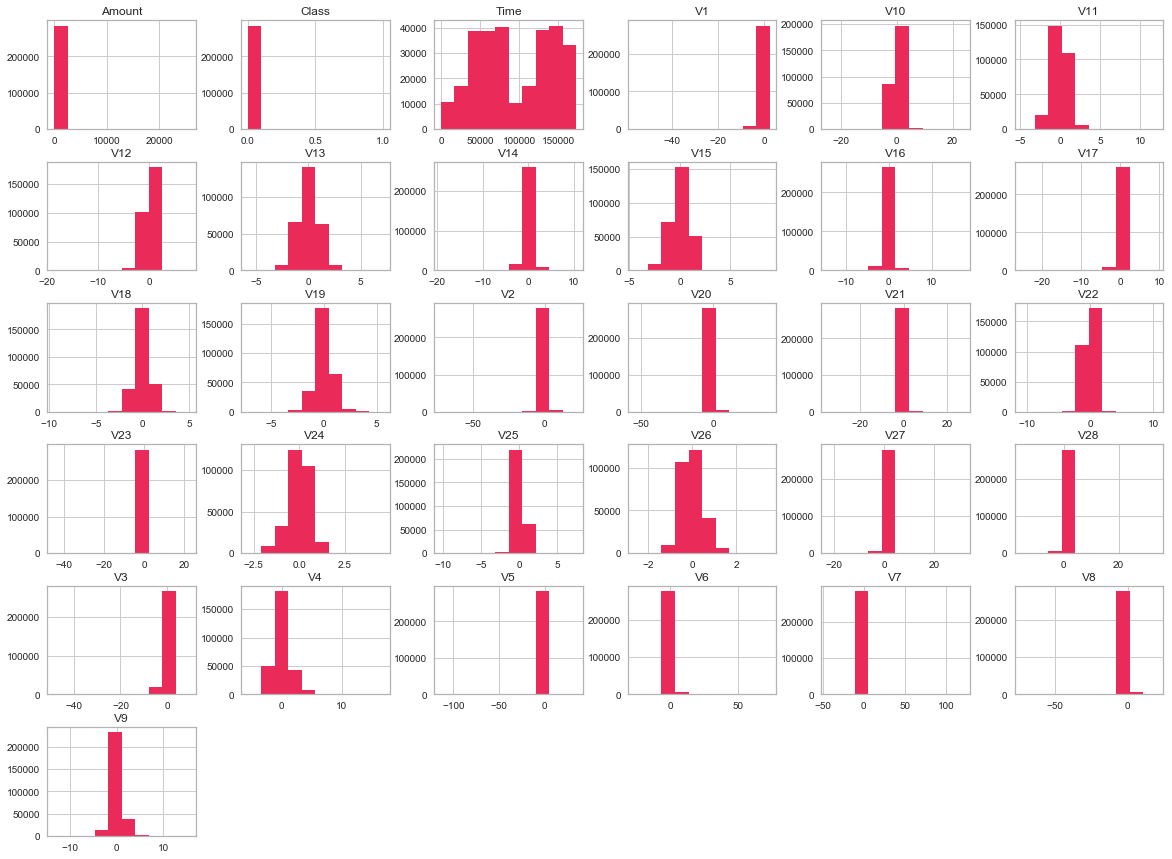

In [7]:
# Verifying the distribution of features 
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
df.hist(column=df.columns, ax=ax);

Many variables are asymmetrical (* skewed *), however anonymous * features * are already the result of a preprocessing (the transformation via PCA), so let's first check the * feature Amount * that has an asymmetric distribution on the right (* positive skewed *).

Amount distribution is not normal
D’Agostino’s K^2 Test: Statistics=588235.01, p=0.00



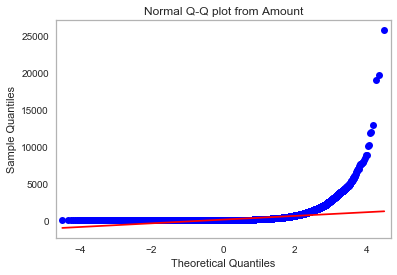

In [8]:
# Testing if it has normal distribution by D'Agostino's K ^ 2 test
# We will not use Shapiro for N> 5000
# Plotting the Normal Q-Q Plot
qqplot(df.Amount, line='s')
plt.title("Normal Q-Q plot from Amount")
stat, p = normaltest(df.Amount)
alpha = 0.05
if (p > alpha):
    print('Amount distribution is normal')
    print('D’Agostino’s K^2 Test: Statistics={:.2f}, p={:.2f}\n'.format(stat, p))
else:
    print('Amount distribution is not normal')
    print('D’Agostino’s K^2 Test: Statistics={:.2f}, p={:.2f}\n'.format(stat, p))

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'norm_list' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'norm_list' kwarg is deprecated, and has been "


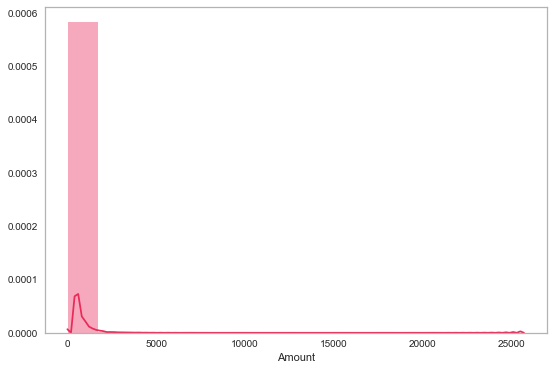

In [9]:
plt.figure(figsize=(9,6))
sns.distplot(df['Amount'], bins = 15);

Checking the target Class is remarkable its unbalance, to verify a little more depth will be plotted separately, also checking the rate of 1 for the total

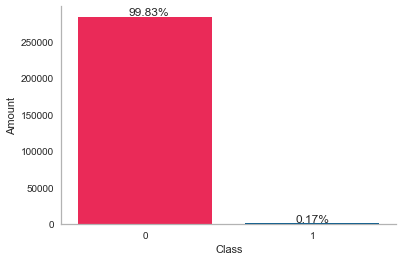

In [10]:
#Plot chart to check unbalance
ax = sns.countplot('Class', data = df, saturation=1)
ax.set_xlabel('Class')
ax.set_ylabel('Amount')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df.shape[0]),
                (i.get_x() + 0.3, i.get_height() + 2000))

sns.despine();

In [11]:
pd.value_counts(df['Class'])

0    284315
1       492
Name: Class, dtype: int64

Because of this imbalance we will have to use some techniques of *oversampling* or *subampling*, to get around this problem, we will talk more about this topic in the near future.
Let's first look at the behavior of the data.

An interesting point is to check in the measure of time, as the * Amount * behaves according to *Class*

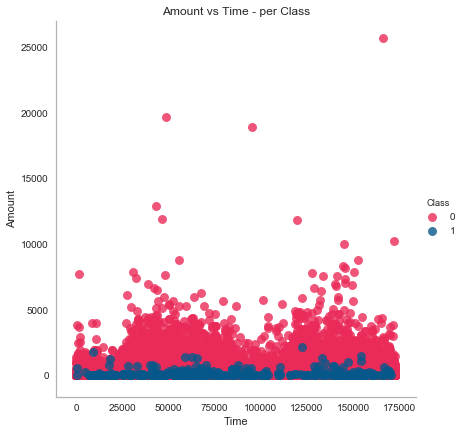

In [12]:
# Plot Amount Chart by Time, separated by Class
sns.lmplot(
    x = 'Time', y ='Amount',
    data = df, hue = "Class",
    fit_reg = False, size = 6,
    scatter_kws = {"s": 80}
); 
ax = plt.gca()
ax.set_xlabel("Time")
ax.set_ylabel("Amount")
ax.set_title("Amount vs Time - per Class");

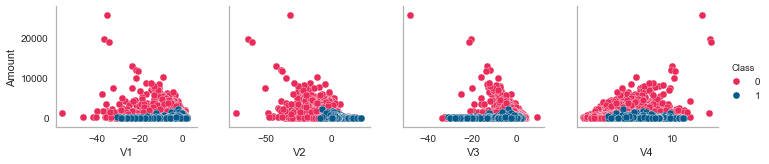

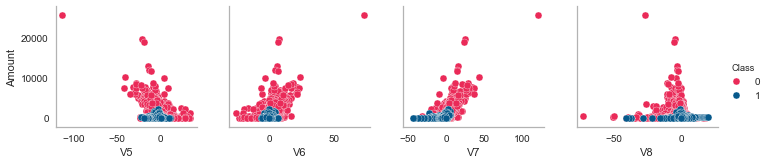

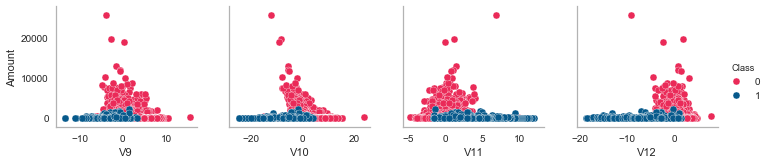

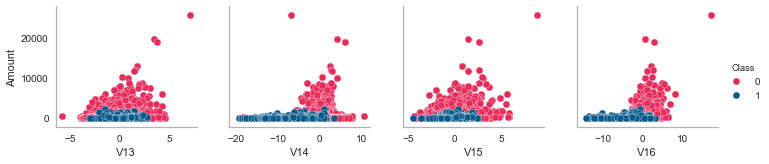

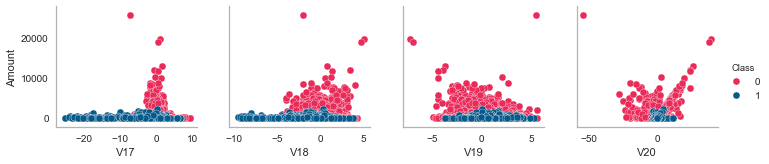

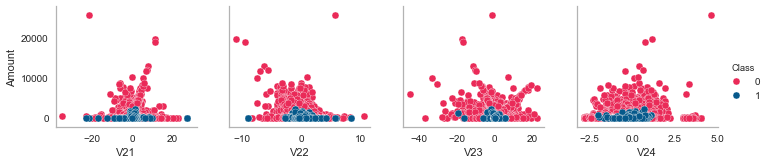

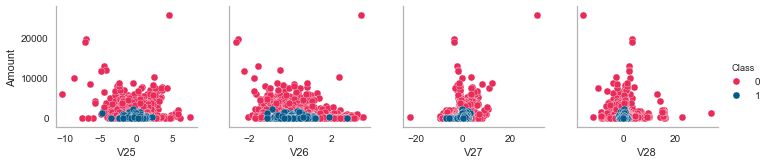

In [13]:
# Plot Amount Chart per Feature
# separated by Class
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V1", "V2", "V3", "V4"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V5", "V6", "V7", "V8"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V9", "V10", "V11", "V12"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V13", "V14", "V15", "V16"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V17", "V18", "V19", "V20"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V21", "V22", "V23", "V24"]
);
sns.pairplot(
    df, hue="Class", 
    y_vars=['Amount'],
    x_vars=["V25", "V26", "V27", "V28"]
);

The dataset to preserve confidentiality has features transformed via PCA previously, so it is expected that they will not have any correlation with each other. To verify this assumption the HeatMap was plotted below, which bought that yes, the features have no correlation.

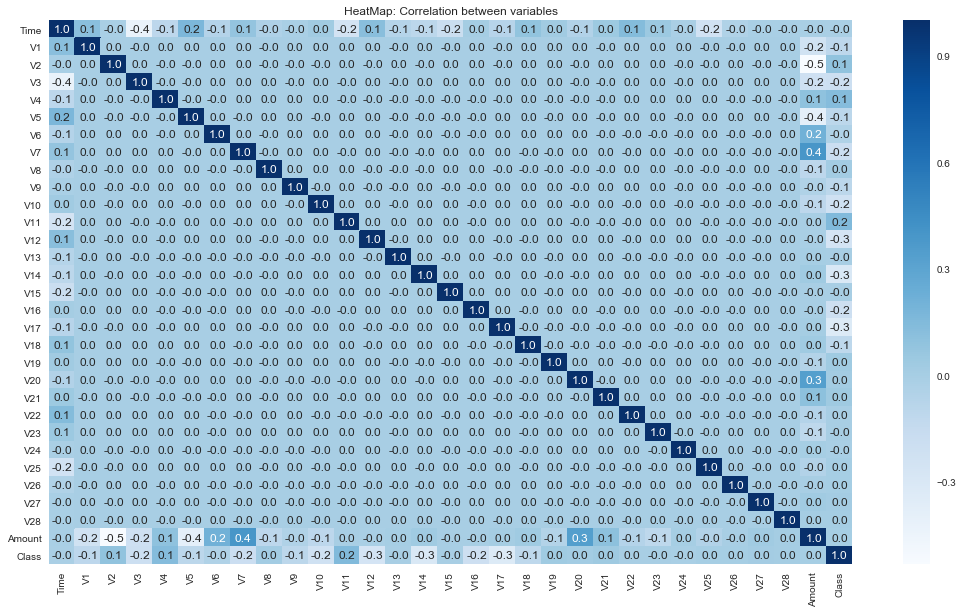

In [14]:
plt.figure(figsize=(18,10))
plt.title('HeatMap: Correlation between variables')
sns.heatmap(df.corr(), annot=True, cmap='Blues', fmt='.1f');

----
## Algorithms and Techniques

In this project we will test four algorithms of the sklearn library, in the intention to choose for the one that obtains a better result in the analyzes. The models used in this study are:

* **Support Vector Machines (SVM)**: uses a technique called kernel to transform data and finds an optimal boundary between possible outputs. It has a high accuracy, is not sensitive to data non-linearity, low risk of overfitting using correct kernels, works well with high dimensional data.

* **Logistic Regression (RL)**: estimates the probability associated with the occurrence of a given event due to some features. It has a high degree of reliability and it is not necessary to assume normality and multicollinearity.

* **Random Forest (RF)**: an ensemble method used to construct a model based on multiple Decision Trees during the training phase. It has a low risk of overfitting, it is usually quick to train, however slow to predict. Better scalability when the dataset is smaller.

* **XGBoost (XGB)**: is an advanced implementation of Gradient Boosting, faster and with high predictive power. It has a variety of regularizations that reduce overfitting and improve overall performance.

The techniques used in this project are:

* **GridSearch**: Optimizes hyperparameters to find the most optimized model possible.

* **Under-sampling**: Removes majority class lines from modeling to avoid unbalance.

* **Over-sampling**: Replicates minority class rows or generates synthetic data to avoid unbalance.

* **Synthetic Minority Over-Sampling Technique (SMOTE)**: Used to synthesize data in over-sampling.

* **Log Transformation**: used to normalize data with asymmetric distribution.

* **MinMaxScaler**: standardizes features on the same scale.


----
## Benchmark

Using the same dataset in the most voted study in Kaggle, the author used a Logistic Regression to create the model that obtained an accuracy and recall about to 93% and, according to Figure 8, obtained the ROC AUC at about 0.95. 

![figura](img/benchmark.png)

----
## Preprocessing
A feature Amount has an asymmetric distribution, so the first step is a log transformation and then a *Feature Scaling*, which consists of rescaling the data to obtain a distribution with average 0 and standard deviation 1. The technique used for this step will be the MinMaxScaler from sklearn, which will transform the data on a scale of 0 to 1.

A new dataframe will be created to store the copied data plus the rescheduling, removed from the original Amount column analyzes.

In [15]:
df_scaled = pd.DataFrame(data = df, copy = True)
df_scaled['logAmount'] = df_scaled['Amount'].apply(lambda x: np.log(x + 1))
df_scaled['MinLogAmount'] = MinMaxScaler().fit_transform(df_scaled['logAmount'].values.reshape(-1, 1))
df_scaled = df_scaled.drop(['Time','Amount', 'logAmount'],axis=1)
df_scaled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,MinLogAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.493873
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.128583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.584923
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.475117
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.419792


### Split data into training and testing
Once we have the data ready to analyze, it is necessary to divide the data between training and test sets, here we use a proportion of 70% for training and 30% for test. Finally, to treat the data imbalance, it was necessary to resample them, using only the training data.

### Unbalance data

To deal with unbalance data, it will be used three techniques: Random Undersampling, Random Oversampling and Oversampling by synthetic data with the *SMOTE with Tomek links*.

**UnderSampling**
This technique consists in removing from the modeling lines of the majority class (*Class = 0*) in a random way. Two new dataframes will be created, one with the same amount of pro-class resources (50%) and the other with 66% normal transactions and 33% fraudulent

In [16]:
data_X = df_scaled.iloc[:, df_scaled.columns != 'Class']
data_y = df_scaled.iloc[:, df_scaled.columns == 'Class']

# Split data in training and testing
X_train, X_test, y_train, y_test = train_test_split(data_X, 
                                                    data_y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

In [17]:
#Store variables in the count of each Class
contagem_classe_0, contagem_classe_1 = y_train.Class.value_counts()
df_train = X_train.join(y_train, lsuffix='X_train', rsuffix='y_train')
#Separate into Dataframes each Class
df_class_0 = df_train[df_train['Class'] == 0]
df_class_1 = df_train[df_train['Class'] == 1]

Randomized Under-sampling amount:
1    345
0    345
Name: Class, dtype: int64


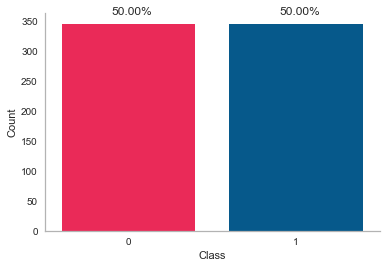

In [18]:
df_class_0_undersample = df_class_0.sample(contagem_classe_1)
df_undersample50 = pd.concat([df_class_0_undersample, df_class_1], axis=0)

under50_X = df_undersample50.iloc[:, df_undersample50.columns != 'Class']
under50_y = df_undersample50.iloc[:, df_undersample50.columns == 'Class']

#Show number of rows for each class
print('Randomized Under-sampling amount:')
print(df_undersample50.Class.value_counts())

#Plot chart to check unbalance
ax = sns.countplot('Class', data = df_undersample50, saturation=1)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_undersample50.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 15))

sns.despine();

Randomized Under-sampling amount:
0    690
1    345
Name: Class, dtype: int64


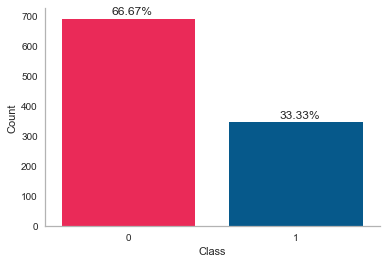

In [19]:
df_class_0_undersample = df_class_0.sample(contagem_classe_1*2)
df_undersample33 = pd.concat([df_class_0_undersample, df_class_1], axis=0)

under33_X = df_undersample33.iloc[:, df_undersample33.columns != 'Class']
under33_y = df_undersample33.iloc[:, df_undersample33.columns == 'Class']

# Show number of rows for each class
print('Randomized Under-sampling amount:')
print(df_undersample33.Class.value_counts())

#Plot chart to check unbalance
ax = sns.countplot('Class', data = df_undersample33, saturation=1)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_undersample33.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 15))

sns.despine();

**Randomized OverSampling**
This technique replicates randomly minority class rows (Class = 1). Two new dataframes will be created, one with the same amount of pro Class resources (50%) and the other with 66% Normal transactions and 33% fraudulent.


Randomized Oversampling amount:
1    199019
0    199019
Name: Class, dtype: int64


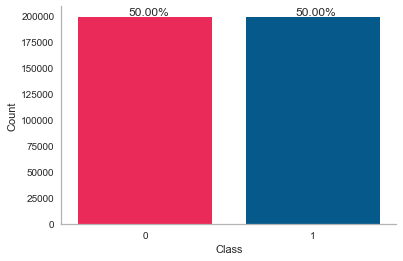

In [20]:
df_class_1_oversample = df_class_1.sample(contagem_classe_0, replace=True)
df_oversample50 = pd.concat([df_class_1_oversample, df_class_0], axis=0)

over50_X = df_oversample50.iloc[:, df_oversample50.columns != 'Class']
over50_y = df_oversample50.iloc[:, df_oversample50.columns == 'Class']

# Show number of rows for each class
print('Randomized Oversampling amount:')
print(df_oversample50.Class.value_counts())

#Plot chart to check unbalance
ax = sns.countplot('Class', data = df_oversample50, saturation=1)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_oversample50.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 1500))

sns.despine();

Randomized Oversampling amount:
0    199019
1     99509
Name: Class, dtype: int64


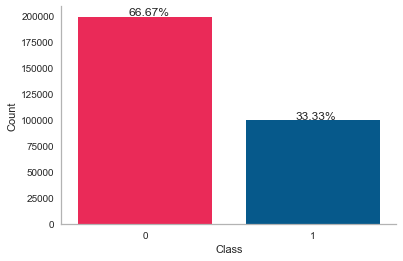

In [21]:
df_class_1_oversample = df_class_1.sample(int(contagem_classe_0/2), replace=True)
df_oversample33 = pd.concat([df_class_1_oversample, df_class_0], axis=0)

over33_X = df_oversample33.iloc[:, df_oversample33.columns != 'Class']
over33_y = df_oversample33.iloc[:, df_oversample33.columns == 'Class']

# Show number of rows for each class
print('Randomized Oversampling amount:')
print(df_oversample33.Class.value_counts())

#Plot chart to check unbalance
ax = sns.countplot('Class', data = df_oversample33, saturation=1)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_oversample33.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 1500))

sns.despine();

**OverSampling SMOTE with Tomek Links**
This technique generates synthetic data by SMOTE, which will be implemented along with *Tomek links* to avoid the increase in variance caused by some synthetic data generation techniques

Two new dataframes will be created, one with the same amount of pro Class resources (50%) and the other with 66% Normal transactions and 33% fraudulent.

In [22]:
features_X = df_scaled.iloc[:, df_scaled.columns != 'Class']
target_y = df_scaled.iloc[:, df_scaled.columns == 'Class']

Total rows in original data:199364
Number of lines per class with SMOTE with Tomek links::
1    199019
0    199019
Name: Class, dtype: int64


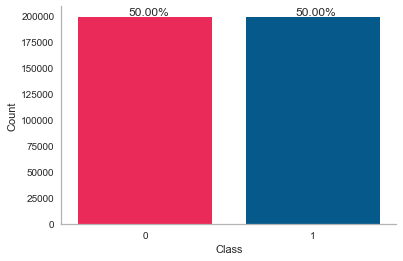

In [23]:
smoteTomek = SMOTETomek(random_state=42)
smote50_X,smote50_y = smoteTomek.fit_sample(X_train, y_train.values.ravel() )

smote50_y = pd.DataFrame(smote50_y)
smote50_y.columns= ['Class']
smote50_X = pd.DataFrame(smote50_X)
smote50_X.columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'MinLogAmount']
df_Smote50 = pd.concat([smote50_y, smote50_X], axis=1)

# Show number of rows for each class
print('Total rows in original data:{}'\
      .format(X_train.shape[0]))
print('Number of lines per class with SMOTE with Tomek links::')
print(df_Smote50.Class.value_counts())

# Plot chart to check unbalance
ax = sns.countplot('Class', data = df_Smote50, saturation=1)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_Smote50.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 1500))

sns.despine();

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Total rows in original data:199364
Number of lines per class with SMOTE with Tomek links::
0    199019
1     99509
Name: Class, dtype: int64


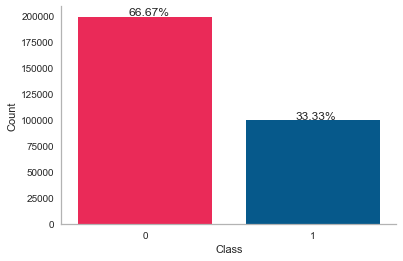

In [24]:
smoteTomek = SMOTETomek(random_state=42,ratio=0.5)
smote33_X,smote33_y = smoteTomek.fit_sample(X_train, y_train.values.ravel() )

smote33_y = pd.DataFrame(smote33_y)
smote33_y.columns= ['Class']
smote33_X = pd.DataFrame(smote33_X)
smote33_X.columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'MinLogAmount']
df_Smote33 = pd.concat([smote33_y, smote33_X], axis=1)

# Show number of rows for each class
print('Total rows in original data:{}'\
      .format(X_train.shape[0]))
print('Number of lines per class with SMOTE with Tomek links::')
print(df_Smote33.Class.value_counts())

# Plot chart to check unbalance
ax = sns.countplot('Class', data = df_Smote33, saturation=1)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
plt.rcParams.update({'font.size': 12})
for i in ax.patches:
    ax.annotate('{:.2f}%'.format(100 * i.get_height() / df_Smote33.shape[0]),
                (i.get_x() + 0.3, i.get_height()+ 1500))

sns.despine();

Now we have 6 datasets to train the algorithms to see which one has the best result.
A brief summary of data sets to facilitate understanding:
* `df_undersample50`: resulting from a random UnderSampling. Class 1: 50% and Class 0: 50%.
* `df_undersample33`: resulting from a random UnderSampling. Class 1: 33% and Class 0: 67%.
* `df_oversample50`: resulting from a random OverSampling. Class 1: 50% and Class 0: 50%.
* `df_oversample33`: resulting from a random OverSampling. Class 1: 33% and Class 0: 67%.
* `df_Smote50`: resulting from a SMOTE with Tomek links. Class 1: 50% and Class 0: 50%.
* `df_Smote33`: resulting from a SMOTE with Tomek links. Class 1: 33% and Class 0: 67%.


----
## Implementation

In this step, a function was created to apply a classifier algorithm without any optimized parameters, showing the results of the metrics mentioned in the chapter **Evaluation metrics** and the time that the algorithm uses to train and predict the data, based on the resulting datasets of resampling. The purpose of this step was to verify which algorithm and resampling technique has the best performance in training and test data to find the best model.

In [28]:
def train_predict(learner, X_train, X_test, y_train, y_test): 

    results = {}
      
    # Fit no algoritmo calculando quanto tempo precisou para treinar
    start = time() 
    learner = learner.fit(X_train,y_train.values.ravel())    
    end = time()     
    results['time_train'] = end - start
        
    # Faz a predição do algoritmo calculando quanto tempo precisou para prever 
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time()
    results['time_pred'] = end - start
                   
    # Calcula o Recall Score nos dados de teste
    results['recall_score_test'] = recall_score(y_test, predictions_test)
            
    # Calcula o ROC_AUC nos dados de teste
    results['roc_auc_test'] = roc_auc_score(y_test, predictions_test)
    
    # Calcula Precision, Recall e f1_Score por classe nos dados de teste
    classification = classification_report(y_test, predictions_test)
    lines = classification.split('\n')
    class_0 = lines[2].split('     ')
    class_1 = lines[3].split('     ')
    results['precision 0'] = float(class_0[3])
    results['recall 0'] = float(class_0[4])
    results['f1_score 0'] = float(class_0[5])
    results['precision 1'] = float(class_1[3])
    results['recall 1'] = float(class_1[4])
    results['f1_score 1'] = float(class_1[5])
       
    # Retorna o resultado
    return results

### Dataframe 1: df_Smote50

In [29]:
# Initializing the models
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Collects the results of the algorithms
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, smote50_X, X_test, smote50_y, y_test)

# Create a dataframe for results
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,1.000000,0.990000,1.000000,1.000000
f1_score 1,0.500000,0.110000,0.850000,0.250000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.390000,0.060000,0.890000,0.150000
recall 0,1.000000,0.980000,1.000000,0.990000
recall 1,0.700000,0.920000,0.810000,0.880000
recall_score_test,0.700680,0.918367,0.809524,0.877551
roc_auc_test,0.849385,0.946827,0.904674,0.934373
time_pred,153.960498,0.062400,0.796601,1.639003
time_train,2423.763670,5.252632,36.449872,123.835850


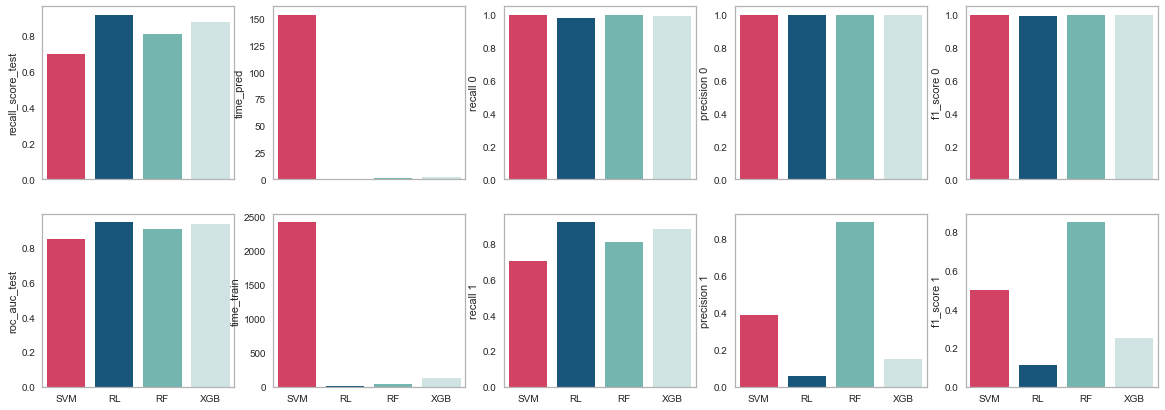

In [30]:
#Transpontando o dataset para plotar
df_scoreT = df_score.T
#Renomeando os algoritmos
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

#Verificando a distribuição das features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);


### Dataframe 2: df_Smote33

In [31]:
# Initializing the models
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Collects the results of the algorithms
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, smote33_X, X_test, smote33_y, y_test)

# Create a dataframe for results
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,1.000000,0.990000,1.000000,1.000000
f1_score 1,0.550000,0.210000,0.850000,0.400000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.460000,0.120000,0.910000,0.260000
recall 0,1.000000,0.990000,1.000000,1.000000
recall 1,0.700000,0.890000,0.800000,0.880000
recall_score_test,0.700680,0.891156,0.802721,0.877551
roc_auc_test,0.849625,0.940021,0.901290,0.936618
time_pred,122.227224,0.031200,0.624001,1.314402
time_train,784.320347,3.445209,26.056667,87.445964


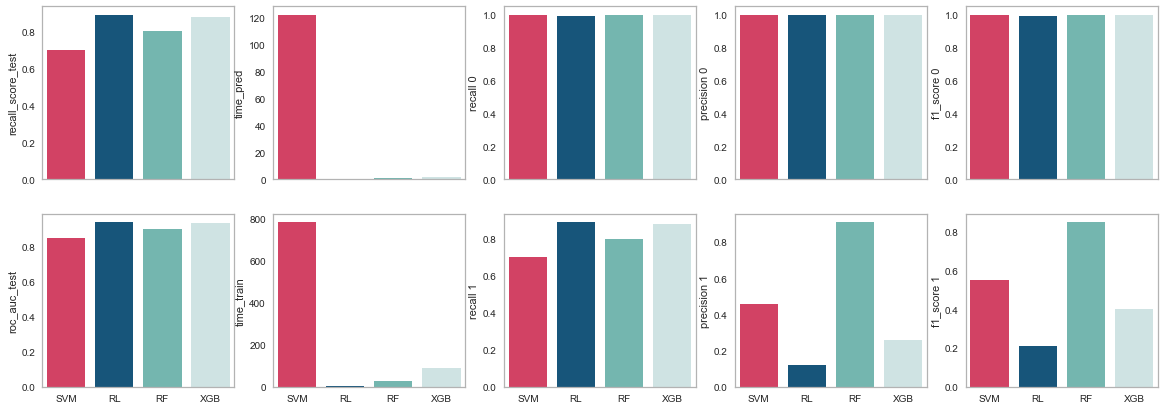

In [32]:
# Transposing the dataset to plot
df_scoreT = df_score.T
# Renaming the algorithms
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

# Checking the distribution of features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

### Dataframe 3: df_undersample50

In [33]:
# Initializing the models
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Collects the results of the algorithms
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, under50_X, X_test, under50_y, y_test)

# Create a dataframe for results
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,0.970000,0.980000,0.980000,0.990000
f1_score 1,0.050000,0.070000,0.090000,0.100000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.030000,0.040000,0.050000,0.050000
recall 0,0.940000,0.960000,0.970000,0.970000
recall 1,0.930000,0.930000,0.910000,0.900000
recall_score_test,0.931973,0.931973,0.911565,0.897959
roc_auc_test,0.936530,0.944010,0.940524,0.934436
time_pred,1.789619,0.000000,0.109200,0.421201
time_train,0.046800,0.015600,0.031200,0.158000


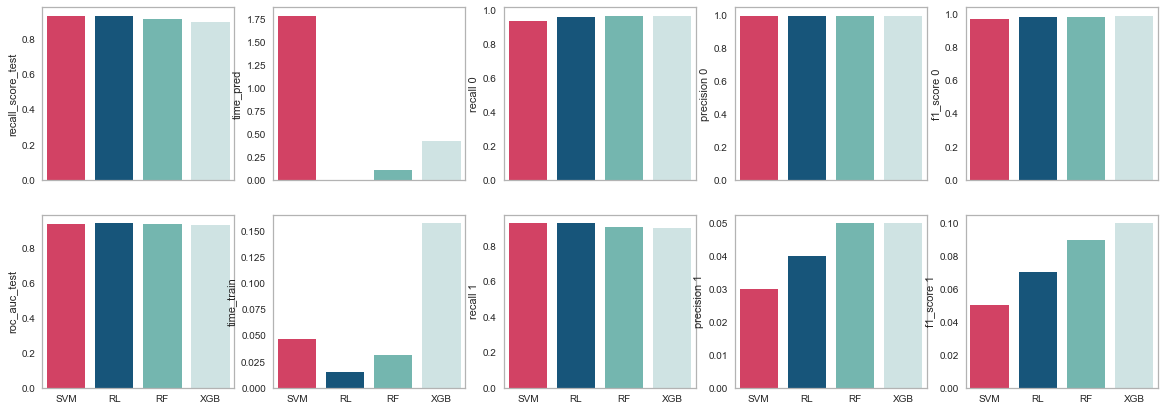

In [34]:
# Transposing the dataset to plot
df_scoreT = df_score.T
# Renaming the algorithms
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

# Checking the distribution of features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

### Dataframe 4: df_undersample33

In [26]:
# Initializing the models
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Collects the results of the algorithms
results = {}
for clf in [
    clf_SVM, clf_RL,
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, under33_X, X_test, under33_y, y_test)

# Create a dataframe for results
df_score = pd.DataFrame(results)  
df_score

NameError: name 'train_predict' is not defined

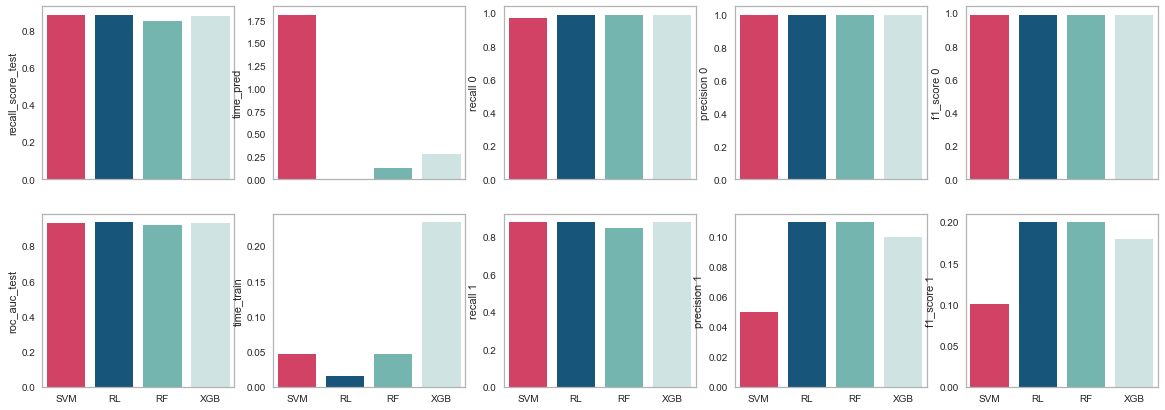

In [36]:
# Transposing the dataset to plot
df_scoreT = df_score.T
# Renaming the algorithms
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

# Checking the distribution of features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

### Dataframe 5: df_oversample50

In [37]:
# Initializing the models
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Collects the results of the algorithms
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, over50_X, X_test, over50_y, y_test)

# Create a dataframe for results
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,1.000000,0.990000,1.000000,1.000000
f1_score 1,0.540000,0.120000,0.850000,0.410000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.450000,0.070000,0.940000,0.270000
recall 0,1.000000,0.980000,1.000000,1.000000
recall 1,0.690000,0.910000,0.770000,0.870000
recall_score_test,0.693878,0.911565,0.768707,0.870748
roc_auc_test,0.846194,0.944568,0.884313,0.933346
time_pred,142.232873,0.046800,0.734201,2.013404
time_train,3297.187725,5.127413,19.321636,100.536405


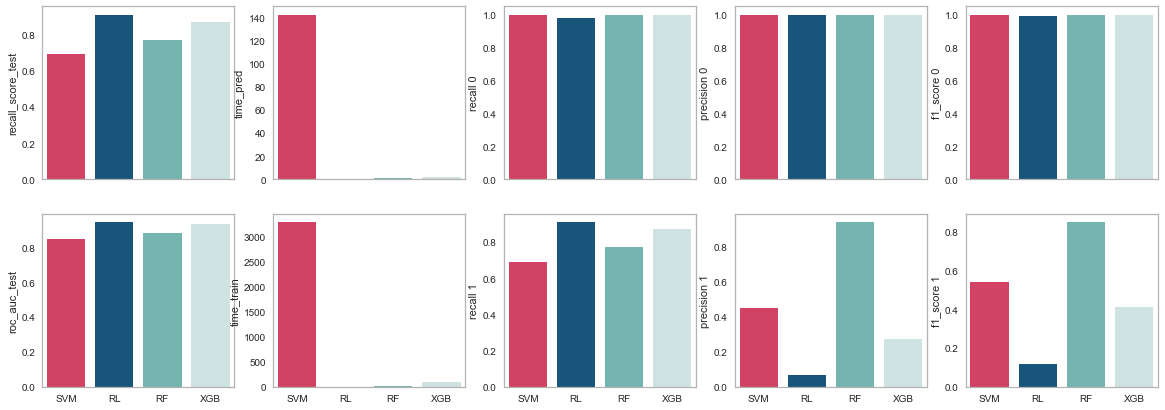

In [38]:
# Transposing the dataset to plot
df_scoreT = df_score.T
# Renaming the algorithms
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

# Checking the distribution of features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

### Dataframe 6: df_oversample33

In [39]:
# Initializing the models
clf_SVM = SVC(random_state=96)
clf_RL= LogisticRegression(random_state=96)
clf_RF = RandomForestClassifier(random_state=96)
clf_XGB = XGBClassifier(random_state=96)

# Collects the results of the algorithms
results = {}
for clf in [
    clf_SVM, clf_RL, 
    clf_RF, clf_XGB
]:
    clf_model = clf.__class__.__name__
    results[clf_model] = train_predict(clf, over33_X, X_test, over33_y, y_test)

# Create a dataframe for results
df_score = pd.DataFrame(results)  
df_score

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,SVC,LogisticRegression,RandomForestClassifier,XGBClassifier
f1_score 0,1.000000,0.990000,1.000000,1.000000
f1_score 1,0.540000,0.220000,0.850000,0.530000
precision 0,1.000000,1.000000,1.000000,1.000000
precision 1,0.450000,0.130000,0.950000,0.390000
recall 0,1.000000,0.990000,1.000000,1.000000
recall 1,0.690000,0.880000,0.760000,0.850000
recall_score_test,0.693878,0.884354,0.761905,0.850340
roc_auc_test,0.846194,0.936989,0.880917,0.924015
time_pred,114.226409,0.031200,0.578201,1.311402
time_train,2826.265561,3.640811,17.948838,79.532763


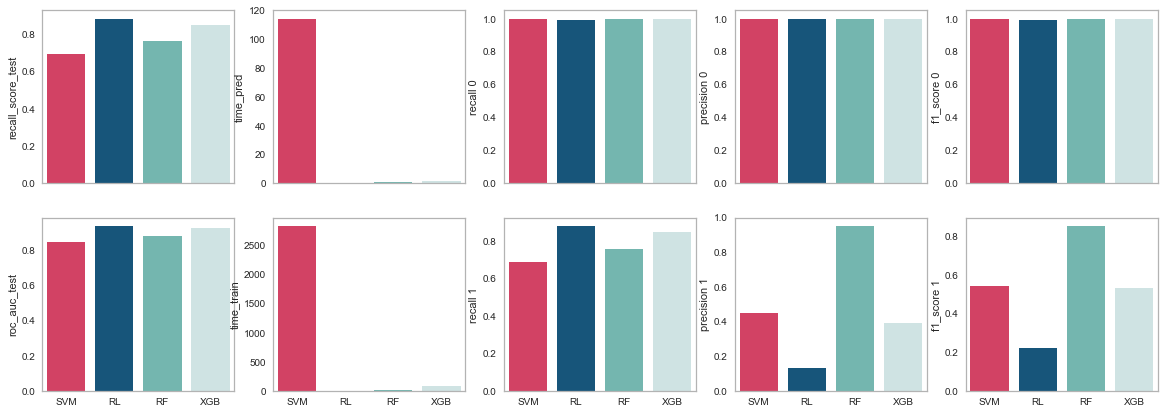

In [40]:
# Transposing the dataset to plot
df_scoreT = df_score.T
# Renaming the algorithms
df_scoreT.rename(index={
    'SVC': 'SVM',
    'LogisticRegression': 'RL',
    'RandomForestClassifier': 'RF',
    'XGBClassifier': 'XGB'
    
}, inplace=True)

# Checking the distribution of features
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True)
sns.barplot( x=df_scoreT.index, y='recall_score_test', 
            data=df_scoreT, ax=axes[0, 0], palette=palette)
sns.barplot( x=df_scoreT.index, y='roc_auc_test', 
            data=df_scoreT, ax=axes[1, 0], palette=palette)

sns.barplot( x=df_scoreT.index, y='time_pred', 
            data=df_scoreT, ax=axes[0, 1], palette=palette)
sns.barplot( x=df_scoreT.index, y='time_train', 
            data=df_scoreT, ax=axes[1, 1], palette=palette)

sns.barplot( x=df_scoreT.index, y='recall 0', 
            data=df_scoreT, ax=axes[0, 2], palette=palette)
sns.barplot( x=df_scoreT.index, y='recall 1', 
            data=df_scoreT, ax=axes[1, 2], palette=palette);

sns.barplot( x=df_scoreT.index, y='precision 0', 
            data=df_scoreT, ax=axes[0, 3], palette=palette)
sns.barplot( x=df_scoreT.index, y='precision 1', 
            data=df_scoreT, ax=axes[1, 3], palette=palette);

sns.barplot( x=df_scoreT.index, y='f1_score 0', 
            data=df_scoreT, ax=axes[0, 4], palette=palette)
sns.barplot( x=df_scoreT.index, y='f1_score 1', 
            data=df_scoreT, ax=axes[1, 4], palette=palette);

We can conclude by observing Table 3 that the RL algorithm with the Smote with Tomek Links technique with equal class balancing obtained the best ROC AUC score (0.947), however the f1_score for class 1 was very low, being 0.110, so the algorithm chosen was the one that performed the best balanced results between the two metrics, being the RF algorithm with the same resampling technique of the above model, obtaining ROC AUC at 0.905 and f1_score at 0.850.	

Having the model and the resampling technique defined, the next step was to optimize the algorithm, using the GridSearch library of sklearn. Here it is important to note that since our evaluation metric will be ROC AUC, having a chosen algorithm, we will use its prediction with probability, which in the case of RF is predict_proba, because, as explained in the chapter on **Evaluation metrics**, the curve ROC AUC is made by varying the threshold to find the false positive / negative rates by calculating the probabilities for each class.

The result of the ROC AUC with predict_proba in the model without refinement was 0.9439, with the following hyperparameters:

In [27]:
print(clf_RF) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=96, verbose=0, warm_start=False)


C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model non-optimized in Original Data Original 
------
ROC_AUC_Score on test data: 0.9439

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.89      0.81      0.85       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.94      0.90      0.92     85443
weighted avg       1.00      1.00      1.00     85443



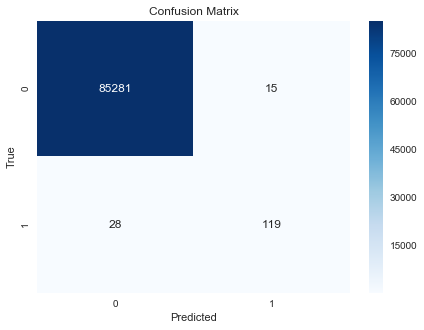

In [28]:
# Make predictions in the non-optimized model with probability and class
clf_proba = clf_RF.fit(smote50_X, smote50_y.values.ravel()).predict_proba(X_test)[:,1]
clf_class = clf_RF.fit(smote50_X, smote50_y.values.ravel()).predict(X_test)

# Score Report
print ("Model non-optimized in Original Data Original \n------")
print ("ROC_AUC_Score on test data: {:.4f}".format(
    roc_auc_score(y_test, clf_proba)))

# Make a heatmap and classification report
cm_test = confusion_matrix(y_test, clf_class)


plt.figure(figsize=(7,5))
sns.heatmap(cm_test, 
            annot = True, 
            cmap = 'Blues', 
            xticklabels = ['0','1'], 
            yticklabels = ['0','1'],
            fmt = '.0f')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

print("\nClassification Report\n")
print(classification_report(y_test, clf_class))

In [29]:
parameters = {
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf':  [4, 5, 6],
             }

# Search for best parameters in parameters with scoring in ROC AUC
grid_obj = GridSearchCV(clf_RF, 
                        parameters, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=5)

# Optimize parameters
grid_fit = grid_obj.fit(smote50_X,smote50_y.values.ravel())

# Recovering the estimator and predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]


print ("\nOptimized model\n------")
print ("Final ROC_AUC_Score on test data: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))



Optimized model
------
Final ROC_AUC_Score on test data: 0.9591


In [30]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=96, verbose=0, warm_start=False)


In [47]:
parameters = {
    'max_depth': [5, 10, 15, 20]
             }

# Search for best parameters in parameters with scoring in ROC AUC
grid_obj = GridSearchCV(RandomForestClassifier(
            min_samples_leaf=5, 
            min_samples_split=2), 
                        parameters, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=5)

# Optimize parameters
grid_fit = grid_obj.fit(smote50_X,smote50_y.values.ravel())

# Recovering the estimator and predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]


print ("\nOptimized model\n------")
print ("Final ROC_AUC_Score on test data: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Optimized model
------
Final ROC_AUC_Score on test data: 0.9735


In [48]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [49]:
parameters = {
    'max_features': ['auto', 'log2']
             }

# Search for best parameters in parameters with scoring in ROC AUC
grid_obj = GridSearchCV(RandomForestClassifier(
            min_samples_leaf=5, 
            min_samples_split=2,
            max_depth=10), 
                        parameters, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=5)

# Optimize parameters
grid_fit = grid_obj.fit(smote50_X,smote50_y.values.ravel())

# Recovering the estimator and predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]


print ("\nOptimized model\n------")
print ("Final ROC_AUC_Score on test data: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))

C:\Users\c211263\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Optimized model
------
Final ROC_AUC_Score on test data: 0.9769


In [58]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=911, n_jobs=None,
            oob_score=False, random_state=96, verbose=0, warm_start=False)


In [50]:
parameters = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)],
             }

# Search for best parameters in parameters with scoring in ROC AUC
grid_obj = GridSearchCV(RandomForestClassifier(
            min_samples_leaf=5, 
            min_samples_split=2,
            max_depth=10,
            max_features='auto',
            random_state=96), 
                        parameters, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=5)

# Optimize parameters
grid_fit = grid_obj.fit(smote50_X,smote50_y.values.ravel())

# Recovering the estimator and predict
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict_proba(X_test)[:,1]


print ("\nOptimized model\n------")
print ("Final ROC_AUC_Score on test data: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))


Optimized model
------
Final ROC_AUC_Score on test data: 0.9820


In [51]:
num = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
for i in num:
    print(i)

200
288
377
466
555
644
733
822
911
1000


With the optimization of the model made in the previous step, the final result of the AUC ROC with predict_proba in the optimized model was 0.9820, with the following hyperparameters:

In [52]:
print(best_clf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=911, n_jobs=None,
            oob_score=False, random_state=96, verbose=0, warm_start=False)



Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.64      0.84      0.73       147

   micro avg       1.00      1.00      1.00     85443
   macro avg       0.82      0.92      0.86     85443
weighted avg       1.00      1.00      1.00     85443



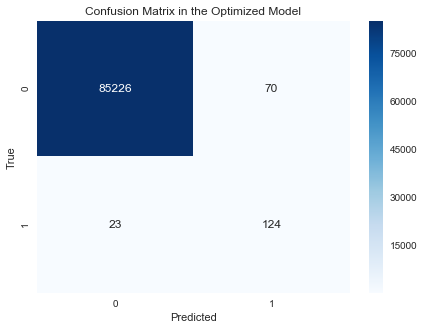

In [53]:
# Make predictions in the optimized model with class
clf_class = best_clf.predict(X_test)

# Make a heatmap and classification report 
cm_test = confusion_matrix(y_test, clf_class)


plt.figure(figsize=(7,5))
sns.heatmap(cm_test, 
            annot = True, 
            cmap = 'Blues', 
            xticklabels = ['0','1'], 
            yticklabels = ['0','1'],
            fmt = '.0f')
plt.title('Confusion Matrix in the Optimized Model')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.savefig('project001_11.png', dpi=1000, 
            transparent=True, bbox_inches='tight', edgecolor=None)

print("\nClassification Report\n")
print(classification_report(y_test, clf_class))

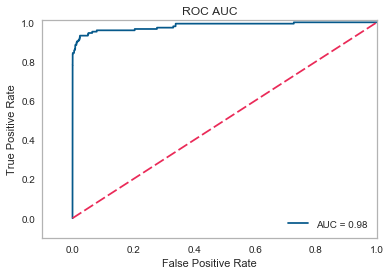

<Figure size 432x288 with 0 Axes>

In [54]:
# ROC AUC CURVE
fpr, tpr, thresholds = roc_curve(y_test,best_predictions)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('ROC AUC')
plt.plot(fpr, tpr,color='#06598b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], '#ea2a58', dashes=[6,2])
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
plt.savefig('project001_09.png', dpi=1000, 
            transparent=True, bbox_inches='tight', edgecolor=None)

### Features Importance

In order to verify which * features * are most relevant to the model, we will use a *sklearn* tool called `feature_importance_`, which calculates the importance of each variable,doing a ranking

In [55]:
# Train the model using the training set
model = clf_RF.fit(smote50_X, smote50_y.values.ravel())

# Extract the importance of features using .feature_importances_
importances = model.feature_importances_

Checking the relevance of each feature in the model the result was that 5 attributes accumulated 70% of the importance of the data, as we can see in figure bellow

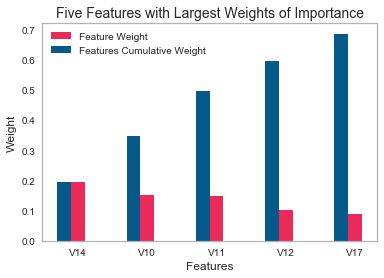

<Figure size 432x288 with 0 Axes>

In [56]:
indices = np.argsort(importances)[::-1]
columns = smote50_X.columns.values[indices[:5]]
values = importances[indices][:5]

# Creat the plot
fig = plt.figure(figsize = (6,4))
plt.title("Five Features with Largest Weights of Importance", fontsize = 14)
plt.bar(np.arange(5), values, width = 0.2, align="center",  \
      label = "Feature Weight")
plt.bar(np.arange(5) - 0.2, np.cumsum(values), width = 0.2, align = "center",  \
      label = "Features Cumulative Weight")
plt.xticks(np.arange(5), columns)
plt.ylabel("Weight", fontsize = 12)
plt.xlabel("Features", fontsize = 12)
plt.legend(loc = 'upper left')
plt.show()


plt.savefig('project001_10.png', dpi=1000, 
            transparent=True, bbox_inches='tight', edgecolor=None)

In [57]:
# Import functionality to clone a template
from sklearn.base import clone

# Reduce the amount of attributes
X_train_reduced = smote50_X[columns]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train the best model found with the previous grid search
clf = (clone(best_clf)).fit(X_train_reduced, smote50_y.values.ravel())

# Make new predictionss
reduced_predictions = clf.predict(X_test_reduced)

# Report the final model scores using both versions of the data
print ("\nOptimized model\n------")
print ("Final ROC_AUC_Score on test data: {:.4f}".format(
    roc_auc_score(y_test, best_predictions)))

print ("\nReduced model\n------")
print ("Final ROC_AUC_Score on Reduced model test data: {:.4f}".format(
    roc_auc_score(y_test, reduced_predictions)))


Optimized model
------
Final ROC_AUC_Score on test data: 0.9820

Reduced model
------
Final ROC_AUC_Score on Reduced model test data: 0.9182


However, when using the same model with only 5 features the ROC AUC dropped to 0.9182, due to the great difference of the metric of both models, the optimized model was chosen with all the features

#### Results:


Comparing the final model with the benchmark and the non-optimized model, it was concluded that the results were improved, being 95% in the benchmark and 98% in the final model, such results can be seen in the table below.

|Metric | Benchmark | Non-optimized model | Optimized model |
| :------------: | :------------:|:------------: | :------------: | 
| ROC AUC |   95%   |  94%  | 98%  |